In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from sklearn.preprocessing import LabelEncoder
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pylab as plt
import pickle

# Generating / Loading table

Loading table

In [2]:
table = pd.read_csv('BR-21.csv')

Generate table

In [3]:
# columns = ['MATCHWEEK','HTEAM','ATEAM','HGK','HDEF1','HDEF2','HDEF3','HDEF4','HDEF5','HMID1','HMID2','HMID3','HMID4','HMID5','HMID6','HFOR1','HFOR2','HFOR3','HFOR4','HFOR5','AGK','ADEF1','ADEF2','ADEF3','ADEF4','ADEF5','AMID1','AMID2','AMID3','AMID4','AMID5','AMID6','AFOR1','AFOR2','AFOR3','AFOR4','AFOR5','HFULLGOAL','AFULLGOAL','FULLRESULT']
# table = pd.DataFrame(columns=columns)

# Functions

In [4]:
def formatstr(string):
    return string.lower().replace(" ","").replace("á","a").replace("ã","a").replace("ê","e").replace("é","e").replace("í","i").replace("ó","o").replace("õ","o").replace("ú","u")

In [5]:
def append_matchweeks(start_matchweek, end_matchweek):
    
    global table
    
    PATH = '/home/matheus/chromedriver'
    driver = webdriver.Chrome(PATH)

    driver.get('https://ge.globo.com/futebol/brasileirao-serie-a/')

    try:
        cookie_btn = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "button.cookie-banner-lgpd_accept-button"))
        )
        cookie_btn.click()
    except:
        print('ALERT: Could not find cookie button.')

    leftarrow = driver.find_element_by_css_selector("span.lista-jogos__navegacao--setas.lista-jogos__navegacao--seta-esquerda")
    rightarrow = driver.find_element_by_css_selector("span.lista-jogos__navegacao--setas.lista-jogos__navegacao--seta-direita")

    matchweek = driver.find_element_by_css_selector("span.lista-jogos__navegacao--rodada").text

    ind = matchweek.index('ª')
    matchweek = matchweek[:ind]

    while matchweek != str(start_matchweek):
        leftarrow.click()
        matchweek = driver.find_element_by_css_selector("span.lista-jogos__navegacao--rodada").text
        ind = matchweek.index('ª')
        matchweek = matchweek[:ind]

    matchweek = int(matchweek)

    while matchweek <= end_matchweek:

        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "a.jogo__transmissao--link"))
            )
            time.sleep(2)
            containers = driver.find_elements_by_css_selector("a.jogo__transmissao--link")
        except:
            driver.quit()
            print('ERROR: Could not find containers.')

        for container in containers:

            actions = ActionChains(driver)

            actions.key_down(Keys.CONTROL).click(container).key_up(Keys.CONTROL).perform()

            time.sleep(1)

            driver.switch_to.window(driver.window_handles[-1])

            ### Getting team names
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "strong.ficha-jogo__time__jogadores__lista__jogador-identificacao"))
                )
                team_names_long = driver.find_elements_by_css_selector("h1.placar__equipe__header__nome")
                team_names_short = driver.find_elements_by_css_selector("h1.ficha-jogo__time__header-sigla")
            except:
                driver.quit()
                print('ERROR: Could not find strong.ficha-jogo...')

            HOME_LONG = formatstr(team_names_long[0].text)
            AWAY_LONG = formatstr(team_names_long[1].text)
            HOME_SHORT = team_names_short[0].text
            AWAY_SHORT = team_names_short[1].text

            ### Getting results
            home_goals = int(driver.find_elements_by_css_selector("strong.placar__equipe__resultado__gols")[0].text)
            away_goals = int(driver.find_elements_by_css_selector("strong.placar__equipe__resultado__gols")[1].text)
            print("{} goals...OK ".format(HOME_LONG.upper()))
            print("{} goals...OK ".format(AWAY_LONG.upper()))
            if home_goals > away_goals:
                FULLRESULT = 'H'
            elif home_goals < away_goals:
                FULLRESULT = 'A'
            elif home_goals == away_goals:
                FULLRESULT = 'D'

            ### Getting Tacticals and Players
            tacticals = driver.find_elements_by_class_name("ficha-jogo__time__esquema")

            home_defenders_number = int(tacticals[0].text.replace(" ","").split("-")[0])
            home_midfielders_number = int(tacticals[0].text.replace(" ","").split("-")[1])
            home_forwards_number = int(tacticals[0].text.replace(" ","").split("-")[2])

            away_defenders_number = int(tacticals[1].text.replace(" ","").split("-")[0])
            away_midfielders_number = int(tacticals[1].text.replace(" ","").split("-")[1])
            away_forwards_number = int(tacticals[1].text.replace(" ","").split("-")[2])
            print("{} tacticals...OK ".format(HOME_LONG.upper()))
            print("{} tacticals...OK ".format(AWAY_LONG.upper()))

            home_players_container = driver.find_elements_by_class_name("ficha-jogo__time__jogadores__lista")[0]
            away_players_container = driver.find_elements_by_class_name("ficha-jogo__time__jogadores__lista")[1]

            home_players = []
            away_players = []

            lis = home_players_container.find_elements_by_tag_name("li")
            for each in lis:
                if (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador") | (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador ficha-jogo__time__jogadores__lista__jogador__substituido ficha-jogo__time__jogadores__lista__jogador__substituido-sai") | (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador ficha-jogo__time__jogadores__lista__jogador__expulso") | (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador ficha-jogo__time__jogadores__lista__jogador__substituido ficha-jogo__time__jogadores__lista__jogador__substituido-sai ficha-jogo__time__jogadores__lista__jogador__expulso"):
                    name = each.find_element_by_css_selector("strong.ficha-jogo__time__jogadores__lista__jogador-identificacao").text
                    home_players.append(name)

            lis = away_players_container.find_elements_by_tag_name("li")
            for each in lis:
                if (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador") | (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador ficha-jogo__time__jogadores__lista__jogador__substituido ficha-jogo__time__jogadores__lista__jogador__substituido-sai") | (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador ficha-jogo__time__jogadores__lista__jogador__expulso") | (each.get_attribute("class") == "ficha-jogo__time__jogadores__lista__jogador ficha-jogo__time__jogadores__lista__jogador__substituido ficha-jogo__time__jogadores__lista__jogador__substituido-sai ficha-jogo__time__jogadores__lista__jogador__expulso"):
                    name = each.find_element_by_css_selector("strong.ficha-jogo__time__jogadores__lista__jogador-identificacao").text
                    away_players.append(name)

            for i, x in enumerate(home_players):
                home_players[i] = formatstr(x)

            for i, x in enumerate(away_players):
                away_players[i] = formatstr(x)

            home_defenders_to_fill = 5 - home_defenders_number
            home_midfielders_to_fill = 6 - home_midfielders_number
            home_forwards_to_fill = 5 - home_forwards_number

            away_defenders_to_fill = 5 - away_defenders_number
            away_midfielders_to_fill = 6 - away_midfielders_number
            away_forwards_to_fill = 5 - away_forwards_number

            for i in range(home_defenders_to_fill):
                home_players.insert(home_defenders_number+1+i, "none")

            for i in range(home_midfielders_to_fill):
                home_players.insert(home_midfielders_number+6+i, "none")

            for i in range(home_forwards_to_fill):
                home_players.insert(home_forwards_number+12+i, "none")        

            for i in range(away_defenders_to_fill):
                away_players.insert(away_defenders_number+1+i, "none")

            for i in range(away_midfielders_to_fill):
                away_players.insert(away_midfielders_number+6+i, "none")

            for i in range(away_forwards_to_fill):
                away_players.insert(away_forwards_number+12+i, "none")

            print("{} players...OK ".format(HOME_LONG.upper()))
            print("{} players...OK ".format(AWAY_LONG.upper()))
            
            ### Appending team short name to players name so they'll be unique values for each player
            for i,x in enumerate(home_players):
                home_players[i] = HOME_SHORT + '_' + x

            for i,x in enumerate(away_players):
                away_players[i] = AWAY_SHORT + '_' + x
                
            ### Generating table observation
            match = [matchweek] + [HOME_LONG.upper()] + [AWAY_LONG.upper()] + home_players + away_players + [home_goals] + [away_goals] + [FULLRESULT]

            series = pd.Series(match, index=table.columns)
            table = table.append(series, ignore_index=True)

            driver.close()

            time.sleep(1)

            driver.switch_to.window(driver.window_handles[0])

            time.sleep(1)

        matchweek += 1
        if matchweek < end_matchweek:
            rightarrow.click()


        time.sleep(2)
    return table

# Web scraping in action

To get full matchweeks, just pass to the function the start_matchweek and end_matchweek parameters to the **append_matchweeks** function

In [6]:
# append_matchweeks(1,36)

# Checking data consistency

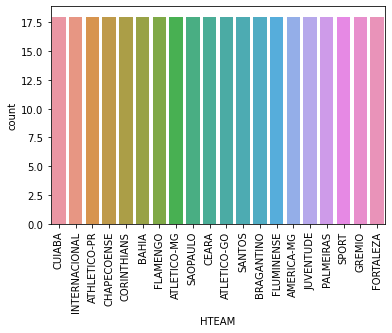

In [7]:
sns.countplot(table['HTEAM'])
plt.xticks(rotation=90)
plt.show()

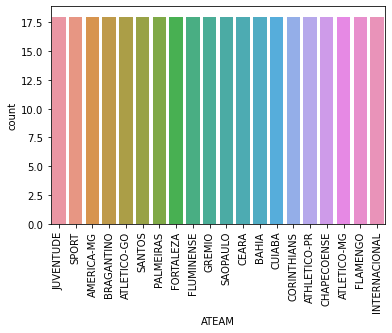

In [8]:
sns.countplot(table['ATEAM'])
plt.xticks(rotation=90)
plt.show()

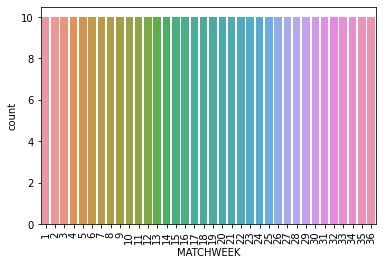

In [9]:
sns.countplot(table['MATCHWEEK'])
plt.xticks(rotation=90)
plt.show()

In [10]:
table.duplicated(subset=['HTEAM','ATEAM']).sum()

0

### Getting X and Y

We are now separating the Features (teams and players) and the Target (match result)

In [11]:
X = table.iloc[:, 1:-3].values
y = table.iloc[:,-1].values

### Label Encoding

In [12]:
labelencoder = LabelEncoder()

for i in range(36):
    X[:,i] = labelencoder.fit_transform(X[:,i])

### Saving table and pickle

In [13]:
# table.to_csv('BR-21.csv', index=False)

In [14]:
# import pickle
# with open('BR-21.pkl', 'wb') as f:
#     pickle.dump([X, y], f)

------